# 2025-10-20 Noisy Data

* Share individual projects, form groups

* Noisy data

* Bias-variance tradeoff

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

# With Chebyshev polynomials
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

# And for piecewise constant interpolation
function interp_nearest(x, s)
    A = zeros(length(s), length(x))
    for (i, t) in enumerate(s)
        loc = nothing
        dist = Inf
        for (j, u) in enumerate(x)
            if abs(t - u) < dist
                loc = j
                dist = abs(t - u)
            end
        end
        A[i, loc] = 1
    end
    A
end

# And our "bad" function
runge(x) = 1 / (1 + 10*x^2)

# And a utility for points distributed via cos
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

# And a helper for looking at conditioning
vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

## Lower-degree polynomials to fit noise-free data

We can fit $m$ data points using an $n < m$ dimensional space of functions.
This involves solving a least squares problem for the coefficients $\min_c \left\lvert \left\lvert V_c - y \right\rvert \right\rvert$.

cond(V) = 4.540300267483982


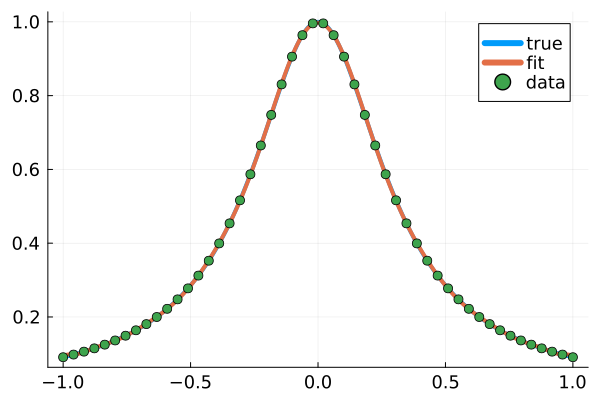

In [2]:
function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    @show cond(V)
    vander_chebyshev(xx, n) / V
end

# More data than points
ndata, nbasis = 50, 20

# Create the problem and fit
x = LinRange(-1, 1, ndata)
xx = LinRange(-1, 1, 500)
C = chebyshev_regress_eval(x, xx, nbasis)

# And plot
plot(xx, [runge.(xx), C * runge.(x)], label=["true" "fit"])
scatter!(x, runge, label="data")

Note that only 20 of the singular values are significant!

size(C) = (500, 50)


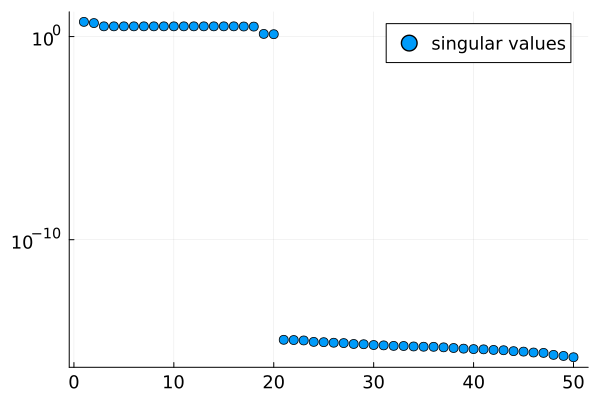

In [3]:
@show size(C)
S = svdvals(C)
scatter(S, yscale=:log10, label="singular values")

## Noisy data

We can take advantage of this least-squares fitting to try to fit the underlying tendency of the data and not overfit to the noise.

cond(V) = 3.2551691693055997


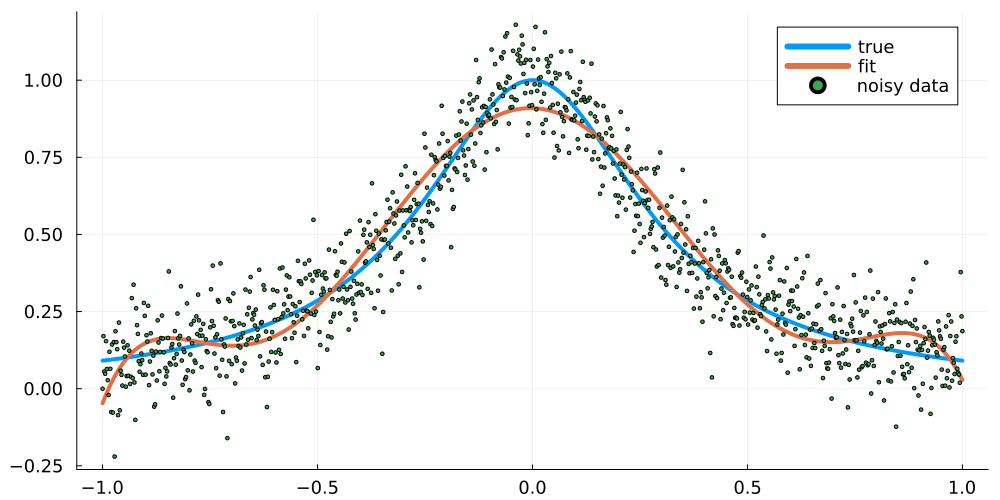

In [4]:
# Let's add noise
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

# Then fit
x = LinRange(-1, 1, 1000)
y = runge_noisy(x, 0.1)
C = chebyshev_regress_eval(x, x, 8)

# And plot
plot(x, [runge.(x), C * y], label=["true" "fit"])
scatter!(x, y, markersize=2, size=(1000, 500), label="noisy data")

What do you like about this fit?
What do you not like?

## Probability distributions and simulation

To interpert real data, we need a model for noise.
We've used the most common and convenient choice when creating the data above; the `randn` function draws from the "standard normal" or "Gaussian" distribution.

$$ p \left( t \right) = \frac{1}{\sqrt{2 \pi}} e^{- t^2 / 2} $$

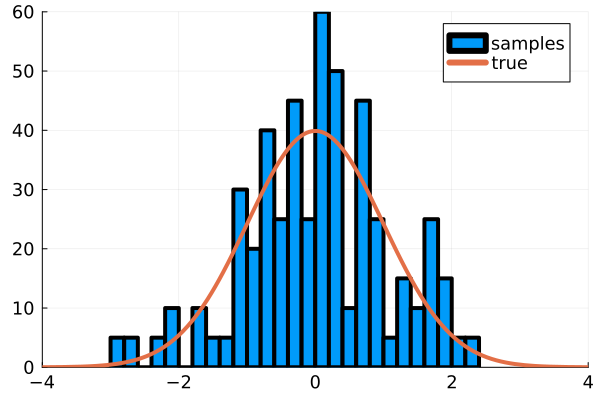

In [5]:
# Let's plot some data from the distribution
stdnormal(t) = exp(-t^2/2.) / sqrt(2*pi)
n = 100
w = randn(n)
histogram(w, bins=40, normalize=:density, xlims=(-4, 4), label="samples")
plot!(t -> n*stdnormal(t), label="true")

## Regression with noisy data

Let's fit multiple curves to some different noisy data.

cond(V) = 3.473045048110251


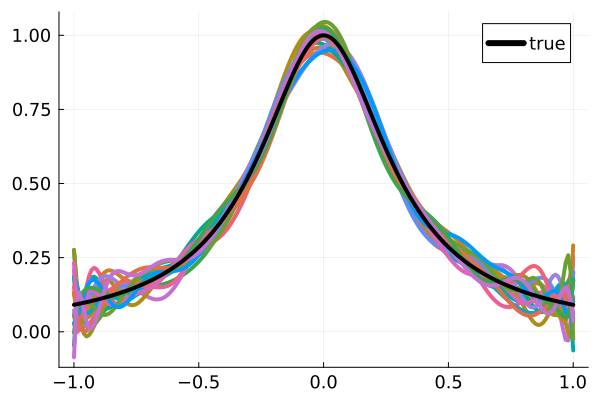

In [6]:
# Function to generate noisy data
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

# Parameters for fit
x = LinRange(-1, 1, 200)
sigma = 0.1
C = chebyshev_regress_eval(x, x, 20)

# Fit many times and plot
plot()
plot!(x, [C * runge_noisy(x, sigma) for n in 1:20], label=:none)
plot!(x, runge.(x), color=:black, label="true")

## Bias-variance tradeoff

The expected error in our approximation $\hat{f} \left( x \right)$ of noisy data $y = f \left( x \right) + \epsilon$ (with $\epsilon \approx \mathcal{N} \left( 0, \sigma \right)$) can be decomposed as

$$ E \left[ \left( \hat{f} \left( x \right) - y \right)^2 \right] = \sigma^2 + \left( \underbrace{ E \left[ \hat{f} \left( x \right) \right] - f \left( x \right)}_{\text{Bias}} \right)^2 + \underbrace{E \left[ \hat{f} \left( x \right)^2 \right] - E \left[ \hat{f} \left( x \right) \right]^2}_{\text{Variance}} $$

The $\sigma^2$ term in irreducible error (purely due to observation noise), but bias and variance can be controlled by model selection.
More complex models are more capable of expressing the underlying function $f \left( x \right)$, and thus are more capable of reducing bias.
However, they are also more affected by noise, thereby increasing variance.

## Changing polynomial degree

What happens as the increase polynomial degree?

(size(ytrain), size(yfit)) = ((500,), (500,))


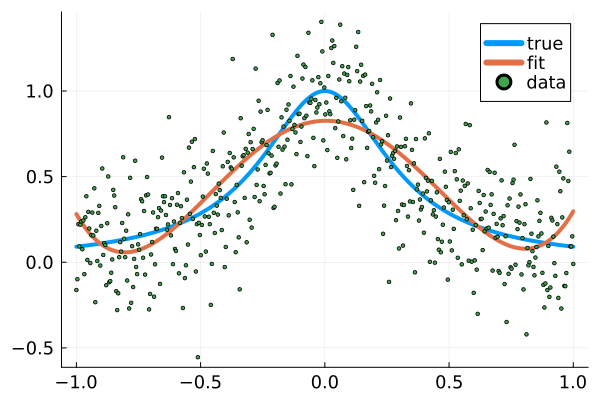

In [7]:
function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    vander_chebyshev(xx, n) / V
end

# First let's make some noisy data
runge(x) = 1 / (1 + 10*x^2)
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

# And fit our model
x = LinRange(-1, 1, 500)
ytrain = runge_noisy(x, 0.25)
yfit = chebyshev_regress_eval(x, x, 5) * ytrain
@show size(ytrain), size(yfit)

# And plot
plot(x, runge.(x), label="true")
plot!(x, yfit, label="fit")
scatter!(x, ytrain, markersize=2, label="data")

Let's make some data and charts that you'll try to interpret.

In [8]:
ytest = runge_noisy(x, 0.25)
@show norm(yfit - ytrain)
@show norm(yfit - ytest);

norm(yfit - ytrain) = 5.705743880514575
norm(yfit - ytest) = 5.7532380918755575


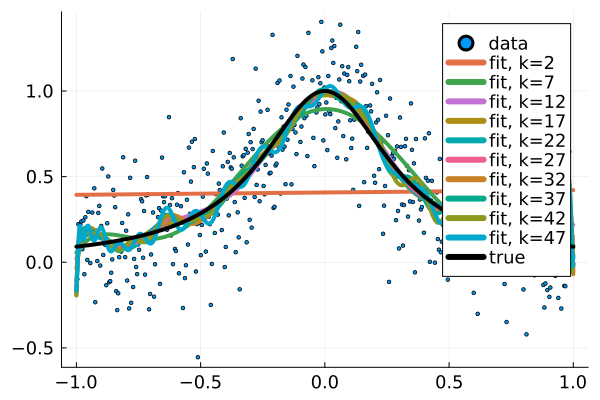

In [9]:
ks = 2:5:50
p = scatter(x, ytrain, markersize=2, label="data")

function residuals(k)
    # Fit polynomial of degree k to ytrain.
    yfit = chebyshev_regress_eval(x, x, k) * ytrain
    plot!(x, yfit, label="fit, k=$k")
    [norm(yfit - ytrain) norm(yfit - ytest)]
end

res = vcat([residuals(k) for k in ks]...)
plot!(x, runge.(x), color=:black, label="true")

size(res) = (10, 2)


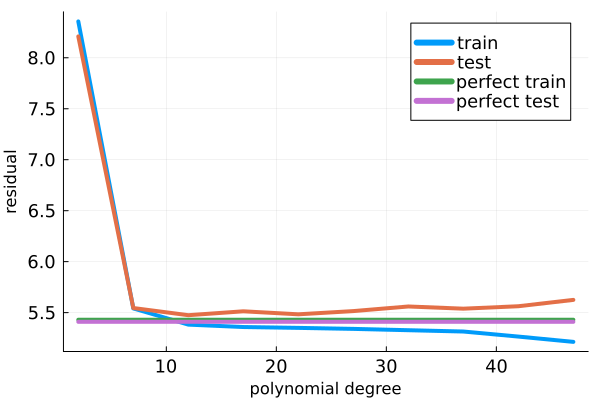

In [10]:
@show size(res)

plot(ks, res[:,1], label="train", xlabel="polynomial degree", ylabel="residual")
plot!(ks, res[:,2], label="test")
plot!(ks, _ -> norm(runge.(x)-ytrain), label="perfect train")
plot!(ks, _ -> norm(runge.(x)-ytest), label="perfect test")

## Exploration

What have we just done?

We took one noisy sample of a function.
We fit polynomials of increasing degree to it.
We then computed the residual of that fit on the training data and an independent "test" sample.

Think about these questions, re-run the notebook, and try to formulate an answer.
Please discuss online (Zulip or with a friend).

* Is "perfect train" (residual for the noisy sample of the zero-noise function) always greater than (or less than) "perfect test"?

* Can you identify when we begin "overfitting" by comparing "train" with "perfect train"?
Does it happen at about the same degree each time?

* In the real world, we don't have access to the zero-noise function, and thus can't mark "perfect train".
By looking at just "train" and "test", can you identify (roughly) when we begin overfitting?

## Stacking many realizations

If each fit will be a bit wrong, let's see if we can identify some underlying tendencies.

Run this cell below for different values of `degree` (set it back to `7` when you're done).

Note that:

* Low-degree polynomials are not rich enough to capture the peak of the function.

* As we increase degree, we are able to resolve the peak better, but see more erratic behavior near the ends of the interval.
This erratic behavior is **overfitting**, which we'll quantify as **variance**.

* This tradeoff is fundamental: richer function spaces are more capable of approximating the functions we want, but they are more easily distracted by noise.

size(Y) = (500, 50)


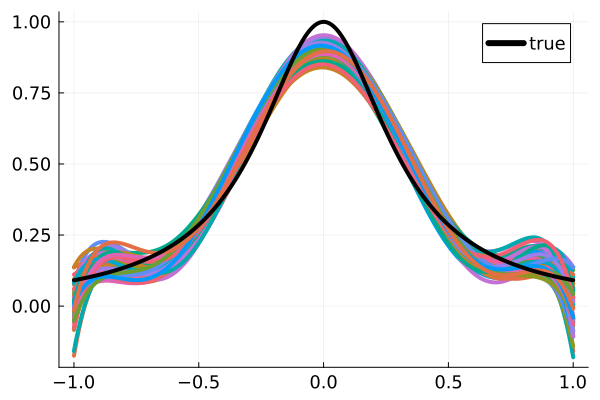

In [11]:
degree = 7
Y = []
for i in 1:50
    yi = runge_noisy(x, 0.25)
    push!(Y, chebyshev_regress_eval(x, x, degree) * yi)
end

Y = hcat(Y...)
@show size(Y) # (number of points in each fit, number of fits)
plot(x, Y, label=nothing);
plot!(x, runge.(x), color=:black, label="true")

### Mean over all the realizations

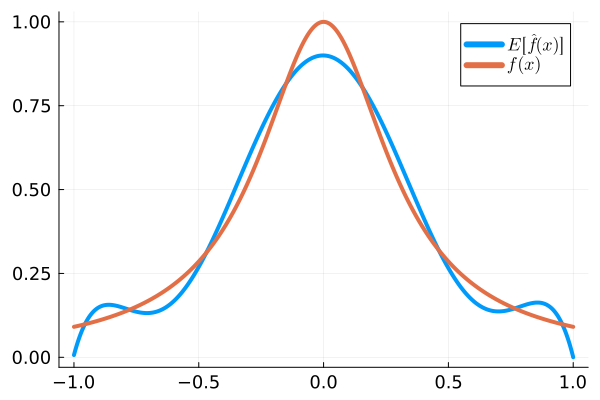

In [12]:
Ymean = sum(Y, dims=2) / size(Y, 2)
plot(x, Ymean, label="\$ E[\\hat{f}(x)] \$")
plot!(x, runge.(x), label="\$ f(x) \$")

### Variance over the realizations

size(Yvar) = (500, 1)


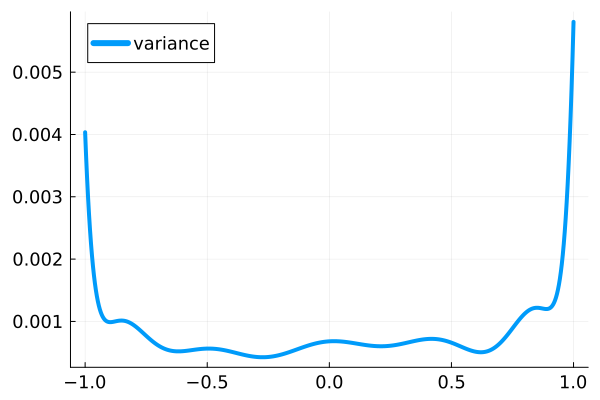

In [13]:
function variance(Y)
    """Compute the Variance as defined at the top of this activity"""
    (sum(Y.^2, dims=2) / size(Y, 2)) - (sum(Y, dims=2) / size(Y, 2)).^2
end

Yvar = variance(Y)
@show size(Yvar)
plot(x, Yvar, label="variance")

## Runge phenomenon - another take

The fact that variance blows up toward the end of our interval is a property of the approximation space (polynomials).
Recall that it doesn't depend on the basis used for fitting (Chebyshev in this case); that choice only relates to stability.
If we could choose an approximation space such that variance was flat across the interval $\left[ -1, 1 \right]$, we would be able to solve interpolation problems on equally spaced grids without numerical artifacts like the Runge phenomenon.
Finding spaces of functions have flat variance and are rich enough to approximate interesting functions is "hard" (e.g. has no general solution).
It is possible in special circumstances, such as for periodic functions, in which the Fourier basis (sine and cosine functions) can be used.

In practice, we often use **regularization** to modify the least squares objective such that we can reduce variance while using function spaces rich enough to keep bias low.